In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
plt.style.use("Solarize_Light2")

In [2]:
churn_data = pd.read_csv(
    '/home/elliot/PycharmProjects/CSC 495 - Telecom Customer Churn/Datasets/telecom_churn_Processed.csv')

X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33, random_state = 42)

## K-Nearest Neighbors:
#### introduction:
The K-Nearest neighbors algorithm is a non-parametric method for classification and regression problems.
In our particular problem instance, it works by classifying new data points based on the classification of its nearest
neighbors from the training data set.

Our first step is to determine what our K should be, to do so we run our KNN model with K=(1..9) to see at which
K we begin to see diminishing returns, which we will choose as the K for our model moving forward.

In [3]:
testscores = []
trainscores = []

for i in range(1, 10):
    model = KNeighborsClassifier(i)
    model.fit(X_train, y_train)

    test_pred = model.predict(X_test)
    train_pred = model.predict(X_train)

    testscores.append(metrics.accuracy_score(y_test, test_pred))
    trainscores.append(metrics.accuracy_score(y_train, train_pred))

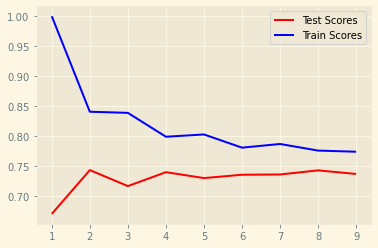

In [4]:
plt.plot(range(1, 10), testscores, label = 'Test Scores', color = 'red')
plt.plot(range(1, 10), trainscores, label = 'Train Scores', color = 'blue')
plt.legend();

We will use K = 8 in our model.
#### First Iteration:

In [5]:
knn = KNeighborsClassifier(8)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
y_pred_knn_train = knn.predict(X_train)

In [6]:
knn_as = metrics.accuracy_score(y_test, y_pred_knn)
knn_as_train = metrics.accuracy_score(y_train, y_pred_knn_train)

In [7]:
print(f"Accuracy score for test data : {knn_as}")
print(f"Accuracy score for train data : {knn_as_train}")

Accuracy score for test data : 0.7423524342955623
Accuracy score for train data : 0.7754192315856506


<AxesSubplot:>

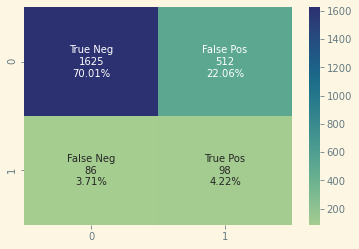

In [8]:
cf_matrix = metrics.confusion_matrix(y_pred_knn, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

In [9]:
print(metrics.classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.76      0.95      0.84      1711
           1       0.53      0.16      0.25       610

    accuracy                           0.74      2321
   macro avg       0.65      0.56      0.55      2321
weighted avg       0.70      0.74      0.69      2321



In [10]:
y_proba = knn.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba)

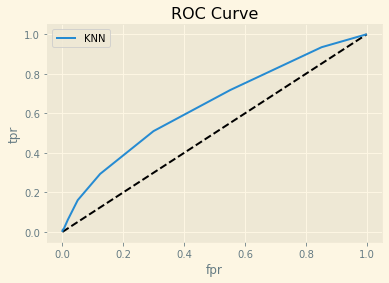

In [11]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'KNN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

In [12]:
metrics.roc_auc_score(y_test, y_proba)

0.6376321008709316

While the results of our first run aren't horrible, I'm concerned by the low recall score for positive churn prediction,
0.16. The model's overall accuracy is okay at 0.74, but not great.

Let's see if we can improve our model results with hyperparameter optimization:

In [13]:
leaf_size = list(range(1,10))
n_neighbors = list(range(1,10))
p=[1,2]
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
best_model = clf.fit(X_train, y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 8


#### Second Iteration w/ Hyperparameter optimization:

In [14]:
knn_hp = KNeighborsClassifier(leaf_size=1, p=1, n_neighbors=8)
knn_hp.fit(X_train, y_train)

y_pred_knn_hp = knn_hp.predict(X_test)
y_pred_knn_train_hp = knn_hp.predict(X_train)

<AxesSubplot:>

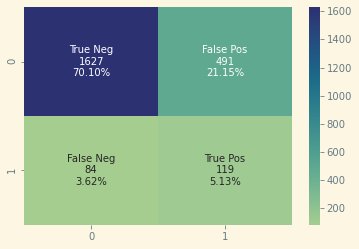

In [15]:
cf_matrix = metrics.confusion_matrix(y_pred_knn_hp, y_test)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = [f"{value}" for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='crest')

              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1711
           1       0.59      0.20      0.29       610

    accuracy                           0.75      2321
   macro avg       0.68      0.57      0.57      2321
weighted avg       0.72      0.75      0.70      2321



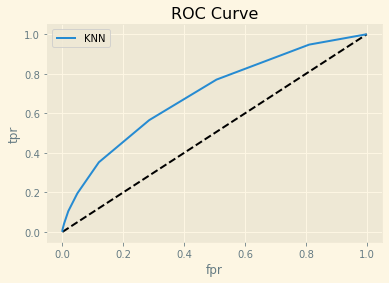

In [16]:
print(metrics.classification_report(y_test, y_pred_knn_hp))
y_proba_hp = knn_hp.predict_proba(X_test)[:, 1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_proba_hp)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label = 'KNN')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('ROC Curve')
plt.legend();

Our hyperparameter optimization was effective, with a .04 increase in positive churn prediction recall, from .16 to .2
while our overall accuracy improved slightly from 0.74 to 0.75.